In [6]:
import pystan 
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.stats import entropy
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras.datasets import mnist
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh

# Custom Function 

In [7]:
def PredictHardClass(model, D_pool):
    '''
    Using the model "model", predict hard classification for each data
    in the D_pool (each row of D_pool)
    Inputs:
        model: sklearn.linear_model e.g. sklearn.linear_model._logistic.LogisticRegression
        D_pool: numpy.ndarray where each row is a data in A.L. pool set
    Outputs:
        T_hat: numpy.ndarray where each row is hard prediction of D_pool
    '''
    T_hat = model.predict(D_pool)
    return T_hat

def PredictSoftClass(model, D_pool):
    '''
    Using the model "model", predict soft classification for each data
    in the D_pool (each row of D_pool)
    Inputs:
        model: Trained CNN Model
        D_pool: numpy.ndarray where each row is a data in A.L. pool set
    Outputs:
        T_proba: numpy.ndarray where each row is soft prediction of D_pool
    '''
    T_proba = model.predict(D_pool)
    return T_proba

def getEntropy(T_proba):
    '''
    Using the soft classification, calculate the entropy for each data
    in the D_pool
    Inputs:
        T_proba: numpy.ndarray where each row is soft prediction of D_pool
    Outputs:
        Ent: numpy.ndarray where each row is entropy of D_pool data
    '''
    N = T_proba.shape[0]
    Ent = np.zeros(N)
    for i in range(N):
        Ent[i] = entropy(T_proba[i], base = 2)
    return Ent

def Find_argmax_AF(n, AF_pool):
    '''
    Using the entropy corresponding to each data point in D_pool, find 'n'
    data points with highest entropy values
    Inputs:
        n: (int) Number of data points to be selected
        AF_pool: numpy.ndarray where each row is entropy of D_pool data
    Outputs:
        arg_nmax: numpy.ndarray with index of 'n' data points with highest
                  entropy values
    '''
    arg_nmax = np.argpartition(AF_pool,-n)[-n:]
    return arg_nmax

def Find_Random(n, len_T_pool):
    '''
    Selecting 'n' random data points
    Inputs:
        n: (int) Number of data points to be selected
        D_pool: numpy.ndarray where each row is a data in A.L. pool set
    Outputs:
        arg_nmax: numpy.ndarray with index of 'n' random data points
    '''
    arg_nmax = np.random.choice(np.arange(len(D_pool)), n, replace=False)
    return arg_nmax

def PicknDelete_4mPool(arg_nmax, D_pool, T_pool, AF):
    '''
    Function to pick data points from D_pool-T_pool using given indices,
    place them in D_select (used later to add to training set) and delete
    the selected data points from D_pool 
    Inputs:
        arg_nmax: numpy.ndarray with index of 'n' data points
        D_pool: numpy.ndarray where each row is a data in A.L. pool set
        T_pool: numpy.ndarray where each row is a label corresponding to
                data in A.L. pool set
        AF: numpy.ndarray where each row is entropy of D_pool data
    Outputs:
        D_select: numpy.ndarray where each row is a data selected from the
                  A.L. pool set
        T_select: numpy.ndarray where each row is a label corresponding to
                  data selected from the A.L. pool set
        D_pool_upd: numpy.ndarray where each row is a data in the depleted
                    A.L. pool set
        T_pool_upd: numpy.ndarray where each row is a label corresponding to
                    data in the depleted A.L. pool set
    '''
    D_select = np.take(D_pool, arg_nmax, axis = 0)
    T_select = np.take(T_pool, arg_nmax, axis = 0)
    AF_select = np.take(AF, arg_nmax, axis = 0)
    
    
    D_pool_upd = np.delete(D_pool, arg_nmax, axis=0)
    T_pool_upd = np.delete(T_pool, arg_nmax, axis=0)
    AF_upd = np.delete(AF, arg_nmax, axis=0)
    return D_select, T_select, D_pool_upd, T_pool_upd

def Add_2Train(D_select, T_select, D_Train, T_Train):
    '''
    Adding selected data points to Train set D_Train-T_Train
    Inputs:
        D_select: numpy.ndarray where each row is a data selected from the
                  A.L. pool set
        T_select: numpy.ndarray where each row is a label corresponding to
                  data selected from the A.L. pool set
        D_Train: numpy.ndarray where each row is a data in the Train set
        T_Train: numpy.ndarray where each row is a label corresponding to
                 data in the Train set
    Outputs:
        D_Train_upd: numpy.ndarray where each row is a data in the updated
                     Train set
        T_Train_upd: numpy.ndarray where each row is a label corresponding to
                     data in the updated Train set
    '''
    D_Train_upd = np.vstack((D_Train, D_select))
    T_Train_upd = np.concatenate([T_Train,T_select])
    return D_Train_upd, T_Train_upd

def ReShape(X, y):
    '''
    Reshape the input to appropriate shape
    Inputs:
        X: numpy.ndarray which is the Raw input
        y: One Hot Vector corresponding to data
    Outputs:
        X_new: flattened numpy.ndarray
        y_new: Label corresponding to data
    '''
    X_shape = X.shape
    X_new = X.reshape(X_shape[0], X_shape[1]*X_shape[2])

    y_new = np.array([np.argmax(yi, axis=None, out=None) for yi in y])

    return X_new, y_new

def Reduce_MNIST_dim(MNIST_Data, dim):
    '''
    
    Inputs:
        
    Outputs:
        
    '''
    MNIST_Data = MNIST_Data/255
    no_data = MNIST_Data.shape[0]
    no_feature = MNIST_Data.shape[1]*MNIST_Data.shape[2]
    
    
    X = np.ones((no_data,no_feature))
    for i in range(no_data):
        X[i] = MNIST_Data[i].flatten()
    standardized_scalar = StandardScaler()
    standardized_data = standardized_scalar.fit_transform(X)
    
    cov_matrix = np.matmul(standardized_data.T, standardized_data)
    
    values, vectors = eigh(cov_matrix, eigvals=(no_feature-dim,no_feature-1))
    vectors = vectors.T
    MNIST_Data_upd = np.matmul(vectors, X.T)
    MNIST_Data_upd = MNIST_Data_upd.T
    
    bias_column = np.ones((no_data,1))
    MNIST_Data_upd = np.append(MNIST_Data_upd, bias_column, axis=1)
    
    return MNIST_Data_upd

# Main Program

In [8]:
# Data Generation and Train, Test, AL Poolset creation
no_classes = 3
no_features = 5
no_samples = 1500
PCA_dim = 12
# Generate Data
#X, y = make_classification(n_samples=no_samples, n_features=no_features, n_informative=3, n_redundant=2, n_classes=no_classes, random_state=1)

(X, y), (D_test, T_test) = mnist.load_data()
X = Reduce_MNIST_dim(X, PCA_dim)
D_test = Reduce_MNIST_dim(D_test,PCA_dim)

# Split Generated Data for initial Training and the Left over part
D_Train, D_pool, T_Train, T_pool = train_test_split(X, y, test_size=0.80, random_state=42)

D_rej, D_pool, T_rej, T_pool = train_test_split(D_pool, T_pool, test_size=0.50, random_state=42)

In [9]:
# Initial Training of data - Model => Logistic Regression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(D_Train, T_Train)

/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [10]:
print(D_Train.shape)
print(D_test.shape)
print(D_pool.shape)
print(T_Train.shape)
print(T_test.shape)
print(T_pool.shape)

(12000, 13)
(10000, 13)
(24000, 13)
(12000,)
(10000,)
(24000,)


In [11]:
# Testing the initial LR model on TEST data
T_test_mod_proba = np.zeros((len(D_test),no_classes))
T_test_mod = np.zeros(len(D_test))
for i in range(len(D_test)):
    T_test_mod_proba = model.predict_proba(D_test)
    T_test_mod= model.predict(D_test)


acc = []
acc.append(accuracy_score(T_test, T_test_mod))

In [14]:
print(T_test_mod.shape)
print(T_test_mod_proba.shape)
acc

(10000,)
(10000, 10)


[0.1466]

# Random Sampling

In [17]:
AL_bound = 1000      # Maximum points that can be chosen from the pool set
no_select = 1       # Points to be selected in each iteration
i = 1
select_count = []
while i <= AL_bound:
    print(i)

    # Selecting Data Points to be moved from the Pool set to the Train set
    T_pool_predproba = PredictSoftClass(model, D_pool)
    AF_Ent = getEntropy(T_pool_predproba)
    arg_nmax = Find_Random(no_select, D_pool)

    D_select, T_select, D_pool, T_pool = PicknDelete_4mPool(arg_nmax, D_pool, T_pool, AF_Ent)
    D_Train, T_Train = Add_2Train(D_select, T_select, D_Train, T_Train)

    # Retraining the model using the updated Train set
    model.fit(D_Train, T_Train)
    
    #Evaluating the updated model
    T_test_mod_proba = PredictSoftClass(model, D_test)
    T_test_mod= PredictHardClass(model, D_test)
        
    acc.append(accuracy_score(T_test, T_test_mod))
    
    
    i = i+no_select  
    select_count.append(i)

1


/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


2


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


3


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


4


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


5


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


6


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


7


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


8


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


9


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


10


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


11


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


12


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


13


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


14


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


15


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


16


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


17


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


18


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


19


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


20


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


21


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


22


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


23


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


24


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


25


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


26


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


27


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


28


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


29


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


30


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


31


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


32


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


33


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


34


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


35


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


36


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


37


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


38


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


39


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


40


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


41


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


42


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


43


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


44


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


45


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


46


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


47


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


48


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


49


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


50


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


51


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


52


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


53


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


54


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


55


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


56


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


57


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


58


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


59


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


60


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


61


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


62


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


63


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


64


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


65


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


66


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


67


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


68


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


69


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


70


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


71


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


72


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


73


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


74


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


75


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


76


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


77


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


78


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


79


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


80


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


81


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


82


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


83


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


84


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


85


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


86


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


87


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


88


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


89


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


90


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


91


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


92


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


93


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


94


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


95


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


96


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


97


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


98


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


99


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


100


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


101


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


102


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


103


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


104


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


105


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


106


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


107


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


108


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


109


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


110


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


111


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


112


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


113


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


114


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


115


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


116


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


117


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


118


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


119


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


120


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


121


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


122


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


123


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


124


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


125


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


126


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


127


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


128


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


129


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


130


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


131


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


132


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


133


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


134


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


135


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


136


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


137


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


138


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


139


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


140


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


141


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


142


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


143


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


144


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


145


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


146


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


147


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


148


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


149


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


150


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


151


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


152


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


153


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


154


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


155


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


156


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


157


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


158


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


159


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


160


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


161


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


162


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


163


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


164


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


165


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


166


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


167


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


168


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


169


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


170


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


171


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


172


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


173


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


174


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


175


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


176


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


177


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


178


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


179


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


180


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


181


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


182


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


183


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


184


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


185


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


186


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


187


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


188


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


189


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


190


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


191


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


192


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


193


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


194


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


195


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


196


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


197


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


198


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


199


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


200


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


201


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


202


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


203


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


204


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


205


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


206


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


207


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


208


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


209


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


210


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


211


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


212


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


213


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


214


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


215


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


216


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


217


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


218


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


219


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


220


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


221


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


222


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


223


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


224


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


225


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


226


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


227


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


228


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


229


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


230


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


231


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


232


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


233


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


234


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


235


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


236


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


237


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


238


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


239


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


240


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


241


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


242


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


243


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


244


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


245


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


246


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


247


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


248


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


249


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


250


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


251


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


252


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


253


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


254


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


255


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


256


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


257


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


258


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


259


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


260


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


261


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


262


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


263


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


264


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


265


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


266


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


267


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


268


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


269


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


270


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


271


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


272


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


273


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


274


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


275


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


276


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


277


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


278


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


279


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


280


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


281


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


282


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


283


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


284


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


285


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


286


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


287


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


288


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


289


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


290


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


291


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


292


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


293


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


294


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


295


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


296


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


297


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


298


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


299


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


300


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


301


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


302


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


303


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


304


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


305


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


306


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


307


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


308


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


309


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


310


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


311


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


312


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


313


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


314


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


315


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


316


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


317


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


318


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


319


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


320


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


321


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


322


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


323


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


324


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


325


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


326


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


327


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


328


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


329


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


330


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


331


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


332


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


333


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


334


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


335


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


336


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


337


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


338


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


339


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


340


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


341


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


342


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


343


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


344


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


345


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


346


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


347


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


348


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


349


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


350


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


351


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


352


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


353


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


354


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


355


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


356


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


357


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


358


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


359


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


360


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


361


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


362


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


363


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


364


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


365


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


366


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


367


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


368


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


369


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


370


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


371


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


372


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


373


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


374


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


375


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


376


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


377


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


378


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


379


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


380


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


381


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


382


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


383


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


384


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


385


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


386


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


387


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


388


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


389


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


390


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


391


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


392


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


393


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


394


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


395


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


396


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


397


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


398


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


399


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


400


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


401


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


402


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


403


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


404


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


405


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


406


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


407


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


408


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


409


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


410


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


411


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


412


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


413


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


414


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


415


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


416


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


417


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


418


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


419


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


420


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


421


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


422


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


423


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


424


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


425


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


426


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


427


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


428


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


429


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


430


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


431


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


432


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


433


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


434


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


435


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


436


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


437


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


438


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


439


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


440


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


441


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


442


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


443


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


444


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


445


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


446


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


447


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


448


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


449


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


450


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


451


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


452


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


453


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


454


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


455


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


456


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


457


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


458


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


459


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


460


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


461


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


462


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


463


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


464


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


465


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


466


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


467


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


468


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


469


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


470


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


471


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


472


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


473


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


474


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


475


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


476


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


477


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


478


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


479


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


480


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


481


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


482


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


483


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


484


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


485


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


486


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


487


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


488


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


489


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


490


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


491


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


492


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


493


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


494


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


495


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


496


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


497


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


498


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


499


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


500


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


501


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


502


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


503


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


504


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


505


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


506


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


507


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


508


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


509


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


510


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


511


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


512


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


513


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


514


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


515


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


516


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


517


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


518


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


519


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


520


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


521


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


522


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


523


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


524


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


525


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


526


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


527


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


528


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


529


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


530


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


531


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


532


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


533


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


534


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


535


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


536


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


537


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


538


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


539


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


540


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


541


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


542


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


543


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


544


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


545


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


546


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


547


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


548


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


549


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


550


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


551


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


552


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


553


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


554


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


555


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


556


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


557


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


558


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


559


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


560


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


561


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


562


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


563


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


564


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


565


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


566


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


567


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


568


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


569


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


570


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


571


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


572


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


573


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


574


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


575


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


576


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


577


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


578


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


579


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


580


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


581


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


582


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


583


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


584


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


585


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


586


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


587


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


588


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


589


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


590


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


591


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


592


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


593


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


594


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


595


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


596


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


597


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


598


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


599


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


600


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


601


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


602


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


603


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


604


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


605


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


606


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


607


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


608


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


609


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


610


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


611


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


612


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


613


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


614


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


615


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


616


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


617


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


618


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


619


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


620


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


621


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


622


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


623


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


624


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


625


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


626


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


627


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


628


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


629


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


630


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


631


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


632


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


633


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


634


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


635


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


636


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


637


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


638


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


639


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


640


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


641


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


642


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


643


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


644


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


645


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


646


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


647


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


648


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


649


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


650


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


651


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


652


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


653


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


654


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


655


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


656


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


657


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


658


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


659


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


660


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


661


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


662


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


663


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


664


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


665


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


666


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


667


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


668


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


669


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


670


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


671


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


672


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


673


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


674


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


675


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


676


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


677


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


678


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


679


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


680


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


681


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


682


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


683


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


684


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


685


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


686


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


687


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


688


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


689


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


690


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


691


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


692


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


693


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


694


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


695


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


696


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


697


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


698


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


699


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


700


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


701


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


702


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


703


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


704


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


705


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


706


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


707


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


708


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


709


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


710


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


711


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


712


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


713


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


714


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


715


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


716


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


717


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


718


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


719


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


720


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


721


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


722


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


723


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


724


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


725


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


726


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


727


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


728


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


729


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


730


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


731


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


732


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


733


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


734


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


735


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


736


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


737


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


738


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


739


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


740


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


741


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


742


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


743


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


744


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


745


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


746


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


747


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


748


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


749


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


750


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


751


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


752


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


753


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


754


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


755


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


756


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


757


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


758


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


759


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


760


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


761


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


762


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


763


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


764


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


765


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


766


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


767


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


768


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


769


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


770


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


771


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


772


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


773


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


774


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


775


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


776


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


777


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


778


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


779


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


780


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


781


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


782


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


783


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


784


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


785


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


786


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


787


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


788


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


789


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


790


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


791


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


792


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


793


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


794


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


795


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


796


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


797


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


798


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


799


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


800


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


801


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


802


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


803


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


804


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


805


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


806


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


807


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


808


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


809


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


810


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


811


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


812


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


813


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


814


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


815


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


816


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


817


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


818


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


819


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


820


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


821


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


822


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


823


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


824


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


825


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


826


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


827


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


828


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


829


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


830


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


831


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


832


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


833


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


834


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


835


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


836


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


837


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


838


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


839


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


840


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


841


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


842


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


843


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


844


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


845


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


846


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


847


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


848


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


849


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


850


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


851


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


852


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


853


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


854


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


855


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


856


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


857


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


858


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


859


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


860


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


861


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


862


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


863


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


864


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


865


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


866


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


867


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


868


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


869


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


870


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


871


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


872


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


873


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


874


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


875


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


876


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


877


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


878


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


879


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


880


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


881


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


882


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


883


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


884


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


885


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


886


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


887


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


888


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


889


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


890


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


891


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


892


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


893


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


894


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


895


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


896


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


897


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


898


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


899


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


900


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


901


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


902


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


903


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


904


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


905


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


906


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


907


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


908


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


909


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


910


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


911


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


912


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


913


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


914


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


915


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


916


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


917


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


918


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


919


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


920


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


921


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


922


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


923


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


924


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


925


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


926


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


927


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


928


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


929


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


930


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


931


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


932


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


933


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


934


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


935


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


936


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


937


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


938


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


939


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


940


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


941


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


942


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


943


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


944


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


945


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


946


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


947


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


948


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


949


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


950


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


951


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


952


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


953


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


954


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


955


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


956


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


957


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


958


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


959


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


960


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


961


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


962


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


963


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


964


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


965


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


966


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


967


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


968


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


969


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


970


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


971


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


972


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


973


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


974


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


975


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


976


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


977


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


978


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


979


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


980


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


981


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


982


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


983


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


984


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


985


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


986


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


987


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


988


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


989


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


990


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


991


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


992


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


993


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


994


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


995


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


996


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


997


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


998


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


999


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


1000


/home/user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
print(len(select_count))
print(len(acc))

1000
1301


# Plots

Text(0, 0.5, 'Accuracy')

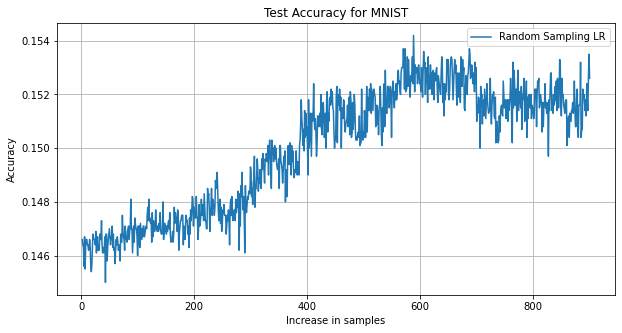

In [25]:
fig = plt.figure(figsize=(10,5))
plt.grid(True, which ="both")
plt.plot(select_count, acc)
plt.legend(['Random Sampling LR'])
plt.title('Test Accuracy for MNIST')
plt.xlabel('Increase in samples')
plt.ylabel('Accuracy')

In [22]:
i

101

In [23]:
len(acc)

151